# Final analysis

This notebook contains the final form of our analysis as well as the final form of the data cleaning process.

In [1]:
from utils import *
from sklearn.linear_model import LogisticRegression

In [2]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
my_colnames = [
                'hidp',
                'sex',
                'jbnssec_dv',
                'jbnssec8_dv',
                'fimnlabgrs_dv',
                'jbstat',
                'jbhrs',
                'jbft_dv',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'paygu_dv',
                'qfhigh',
                'qfhigh_dv',
                'istrtdatm',
                'istrtdaty',
                'month',
                'indscus_xw',
                'indinus_lw',
                'indinub_lw',
                'indinui_lw'
]

In [3]:
data = load_data(path, my_colnames)

/home/daniel/code/costofcare/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wave'] = i+1


In [4]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
my_colnames = ['hidp', 'fihhmngrs_dv']
data_h = load_data_h(path, my_colnames)

In [5]:
data = pd.merge(data, data_h, on=['hidp', 'wave'])

In [6]:
cpih = pd.read_csv('./data/cpih_uk_88_23.csv')
data_clean = recoding_and_cleaning(data, cpih)

/home/daniel/code/costofcare/utils.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jbhrs_clean'][data.jbhrs_clean < 1] = np.nan


<AxesSubplot: >

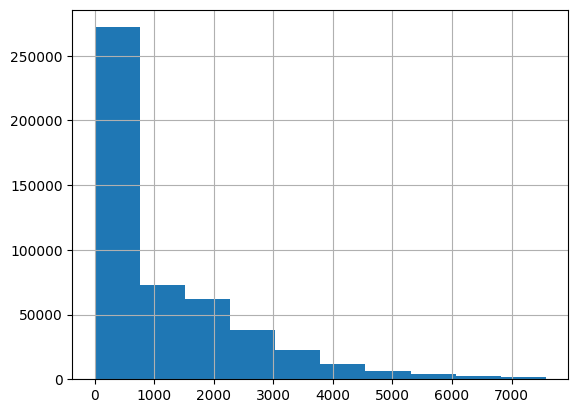

In [7]:
data_clean.ind_inc_deflated.hist()

In [8]:
data_clean['treated'] = data_clean['aidhrs_recoded_3'].transform(pd.notnull)
data_clean['control'] = data_clean['aidhrs'] == 'inapplicable'
data_clean['ever_treated'] = data_clean.groupby('pidp')['treated'].transform(any).values

In [9]:
data_clean['edu_3'] = data_clean.edu_3.replace({1.0: 'low', 2.0:'middle', 3.0:'high'})

In [10]:
data_clean.employed.value_counts()

employed        276897
unemployed      223525
inapplicable         1
Name: employed, dtype: int64

In [11]:
dummies = pd.get_dummies(data_clean.ethn_5)
edu_dumm = pd.get_dummies(data_clean.edu_3)
data_final = pd.concat([data_clean, dummies, edu_dumm], axis=1)

In [12]:
data_final['inc_share'] = (data_final['ind_inc_deflated'] / data_final['hh_inc_deflated']) * 100

In [13]:
data_final.loc[data_final['inc_share'] > 100, 'inc_share'] = np.nan

### Prob of employment calculation

/tmp/ipykernel_3330/1504701429.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'prob_employed_x'} in the result is deprecated and will raise a MergeError in a future version.
  out = out.merge(df_year[['pidp', 'year', 'prob_employed']], on=['pidp', 'year'], how='outer')
/tmp/ipykernel_3330/1504701429.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'prob_employed_x'} in the result is deprecated and will raise a MergeError in a future version.
  out = out.merge(df_year[['pidp', 'year', 'prob_employed']], on=['pidp', 'year'], how='outer')
/tmp/ipykernel_3330/1504701429.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'prob_employed_x'} in the result is deprecated and will raise a MergeError in a future version.
  out = out.merge(df_year[['pidp', 'year', 'prob_employed']], on=['pidp', 'year'], how='outer')
/tmp/ipykernel_3330/1504701429.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'prob_employ

<AxesSubplot: >

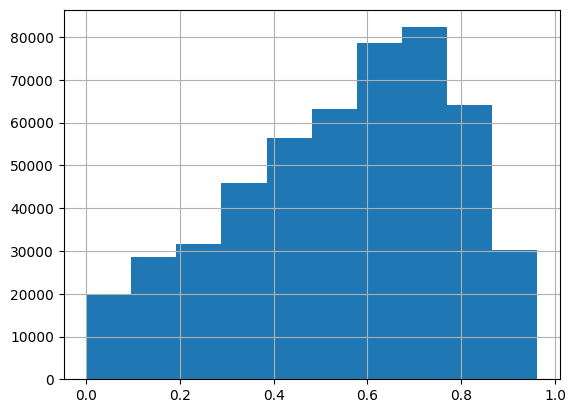

In [14]:
df = data_final.copy()
df['employed'] = df.employed.replace({"inapplicable": np.nan,
                                     'employed': 1,
                                     'unemployed': 0})
years = df.year.dropna().unique()
out = df[['pidp', 'year']]
for year in years:
    df_year = df[df.year==year][['pidp', 'year', 'employed', 'treated', 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other', 'high', 'middle', 'mastat_recoded']].dropna()
    y_year = df_year['employed']
    X_year = df_year[['treated', 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other', 'high', 'middle', 'mastat_recoded']]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_year, y_year)
    df_year['prob_employed'] = [x[1] for x in clf.predict_proba(X_year)]
    out = out.merge(df_year[['pidp', 'year', 'prob_employed']], on=['pidp', 'year'], how='outer')
out['prob_emp'] = out.iloc[:, 2:].sum(axis=1)
out = out[['pidp', 'year', 'prob_emp']]
out.prob_emp.hist()

In [15]:
data_final = data_final.merge(out, on=['pidp', 'year']).copy()
treated_f = data_final[data_final.ever_treated].copy()
control_f = data_final[~data_final.ever_treated].copy()

In [16]:
print(set(control_f.pidp.unique()) & set(treated_f.pidp.unique()))
common_elements = [item for item in control_f.pidp.unique() if item in treated_f.pidp.unique()]
print(any(common_elements))

set()
False


In [17]:
treated_f.to_csv('./data/treated_cases.csv')
control_f.to_csv('./data/control_cases.csv')

In [18]:
conds = {
    'employed': False,
    'dropna': True,
    'target_var': 'hh_inc_deflated',
    'min_treat_waves': 1,
    'min_waves_pretreat': 4
}

In [19]:
treated_ii, control_ii = isc_data_preparation(data_final, conds)

In [20]:
treated_ii.to_csv('./strata/hhi_t_full.csv')
control_ii.to_csv('./strata/hhi_c_full.csv')

In [18]:
treated_ii = pd.read_csv('./strata/ii_t_full.csv')

In [19]:
dummies = pd.get_dummies(treated_ii.aidhrs_recoded_3)
treated_d = pd.concat([treated_ii, dummies], axis=1)
idx = treated_d[treated_d.year == treated_d.year_treated]
idxh = idx[idx['0-19']==0].pidp
idxl = idx[idx['0-19']==1].pidp
treated_d[treated_d.pidp.isin(idxh)].to_csv('./strata/hhi_t_hi.csv')
treated_d[treated_d.pidp.isin(idxl)].to_csv('./strata/hhi_t_li.csv')

In [27]:
ii_t_li = pd.read_csv('./strata/ii_t_li.csv')
ii_t_li['reindex'].value_counts().sort_index()

-11     163
-10     484
-9      855
-8     1301
-7     1856
-6     2528
-5     3619
-4     4844
-3     6341
-2     6341
-1     6341
 0     6341
 1     5398
 2     4501
 3     3741
 4     3026
 5     2363
 6     1678
 7      882
 8      324
Name: reindex, dtype: int64

<AxesSubplot: >

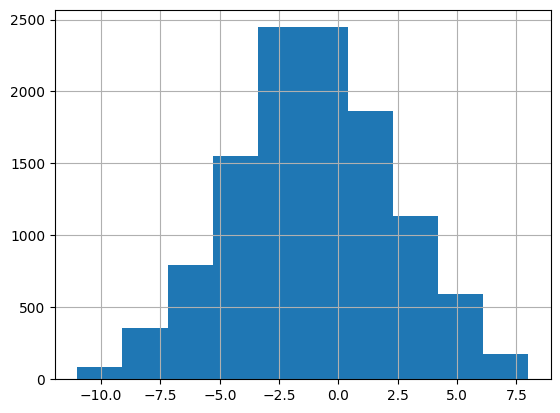

In [24]:
ii_t_hi = pd.read_csv('./strata/ii_t_hi.csv')
ii_t_hi['reindex'].hist()

## Stratification for high intensity carers only

In [3]:
ii_t_hi = pd.read_csv('./strata/hhi_t_li.csv')
control_ii = pd.read_csv('./strata/hhi_c_full.csv')

/tmp/ipykernel_28740/4129287115.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ii_t_hi = pd.read_csv('./strata/hhi_t_li.csv')
/tmp/ipykernel_28740/4129287115.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  control_ii = pd.read_csv('./strata/hhi_c_full.csv')


In [22]:
ii_t_hi[ii_t_hi.sex=='female'].to_csv('./strata/hhi_t_li_f.csv')
control_ii[control_ii.sex=='female'].to_csv('./strata/hhi_c_li_f.csv')
ii_t_hi[ii_t_hi.sex=='male'].to_csv('./strata/hhi_t_li_m.csv')
control_ii[control_ii.sex=='male'].to_csv('./strata/hhi_c_li_m.csv')

In [ ]:
ii_t_hi[ii_t_hi.ethn_5=='white'].to_csv('./strata/hibyeth/ii_t_hi_w.csv')
control_ii[control_ii.ethn_5=='white'].to_csv('./strata/hibyeth/ii_c_hi_w.csv')
ii_t_hi[ii_t_hi.ethn_5!='white'].to_csv('./strata/hibyeth/ii_t_hi_nw.csv')
control_ii[control_ii.ethn_5!='white'].to_csv('./strata/hibyeth/ii_c_hi_nw.csv')

In [4]:
ii_t_hi[ii_t_hi.edu_3=='low'].to_csv('./strata/hhi_t_li_edl.csv')
control_ii[control_ii.edu_3=='low'].to_csv('./strata/hhi_c_li_edl.csv')
ii_t_hi[ii_t_hi.edu_3=='middle'].to_csv('./strata/hhi_t_li_edm.csv')
control_ii[control_ii.edu_3=='middle'].to_csv('./strata/hhi_c_li_edm.csv')
ii_t_hi[ii_t_hi.edu_3=='high'].to_csv('./strata/hhi_t_li_edh.csv')
control_ii[control_ii.edu_3=='high'].to_csv('./strata/hhi_c_li_edh.csv')

In [24]:
ii_t_hi[ii_t_hi.mastat_recoded==1].to_csv('./strata/hibymar/ii_t_hi_mar.csv')
control_ii[control_ii.mastat_recoded==1].to_csv('./strata/hibymar/ii_c_hi_mar.csv')
ii_t_hi[ii_t_hi.mastat_recoded==0].to_csv('./strata/hibymar/ii_t_hi_sin.csv')
control_ii[control_ii.mastat_recoded==0].to_csv('./strata/hibymar/ii_c_hi_sin.csv')